loading annotations into memory...
Done (t=2.73s)
creating index...
index created!
Total images in dataset: 5000


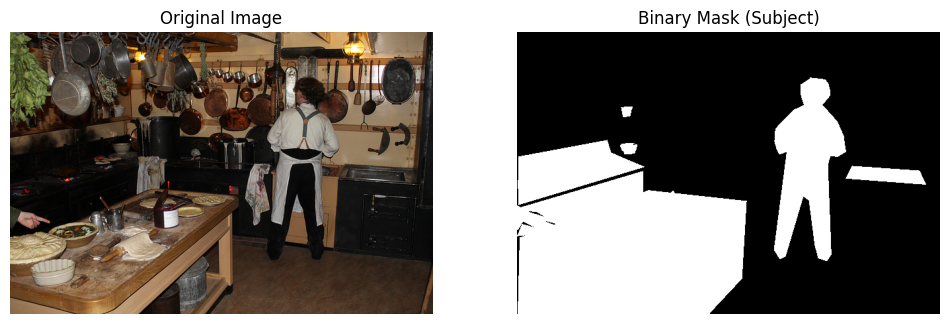

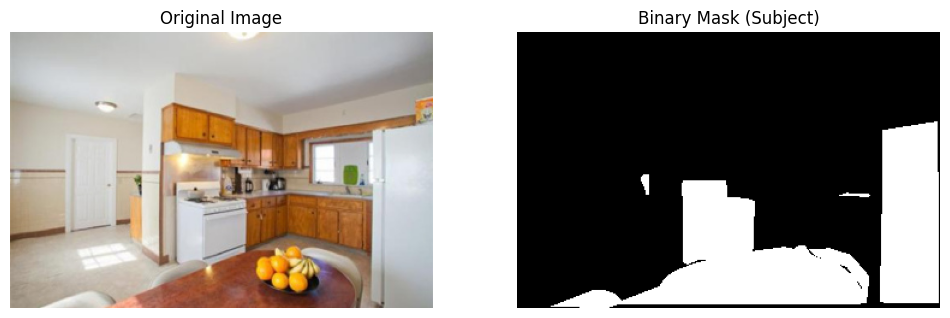

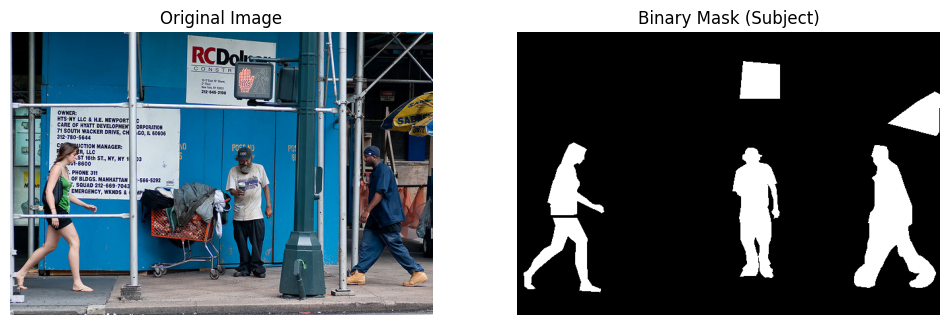

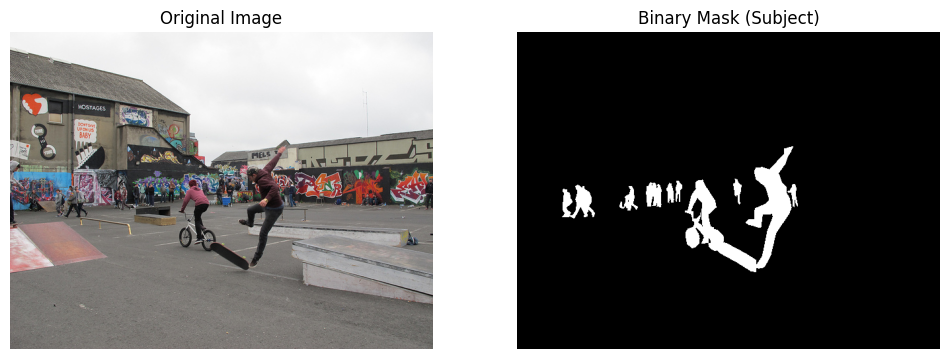

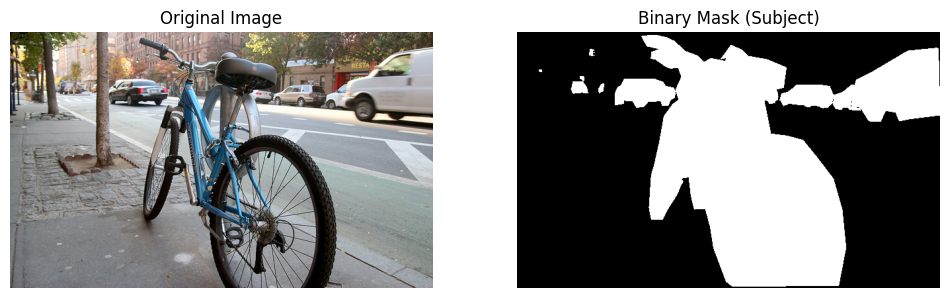

In [7]:
#Week 1

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from pycocotools.coco import COCO
from tensorflow.keras.preprocessing.image import ImageDataGenerator


DATA_ROOT = "/content/drive/MyDrive/VisionAI"
IMAGES_DIR = os.path.join(DATA_ROOT, "val2017")  # or train2017
ANN_FILE = os.path.join(DATA_ROOT, "annotations", "instances_val2017.json")

coco = COCO(ANN_FILE)
img_ids = coco.getImgIds()
print("Total images in dataset:", len(img_ids))

def build_binary_mask(coco, img_info):
    # Get all annotations for this image
    ann_ids = coco.getAnnIds(imgIds=img_info['id'], iscrowd=False)
    anns = coco.loadAnns(ann_ids)

    # Empty mask
    mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)

    # Add each object’s mask
    for ann in anns:
        mask = np.maximum(mask, coco.annToMask(ann))

    # Convert to binary: 0 = background, 1 = subject
    mask = np.clip(mask, 0, 1)
    return mask

for img_id in img_ids[:5]:
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(IMAGES_DIR, img_info['file_name'])

    img = cv2.imread(img_path)
    if img is None:
        print("Image missing:", img_path)
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask = build_binary_mask(coco, img_info)

    plt.figure(figsize=(12,6))

    # Original image
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis("off")

    # Binary mask
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap="gray")
    plt.title("Binary Mask (Subject)")
    plt.axis("off")

    plt.show()

loading annotations into memory...
Done (t=0.63s)
creating index...
index created!
Total images: 5000


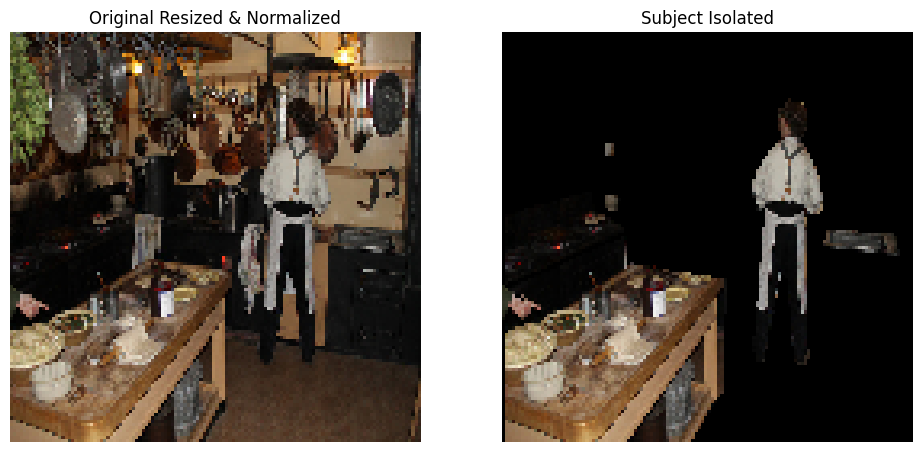

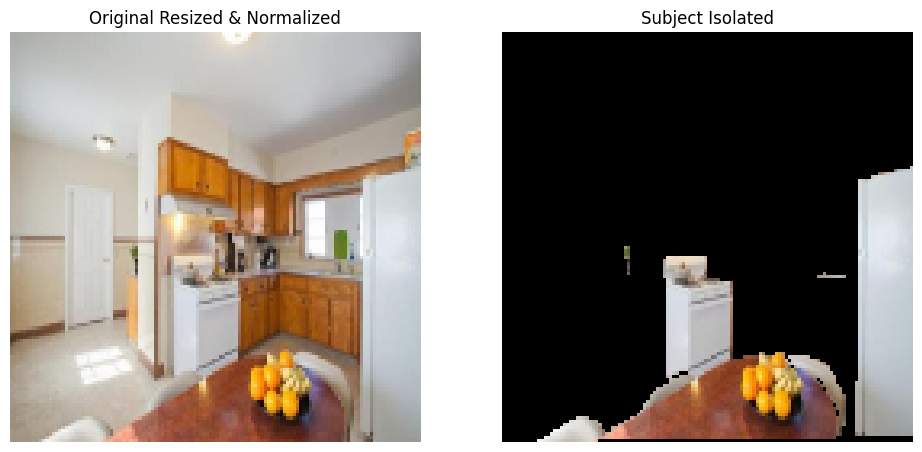

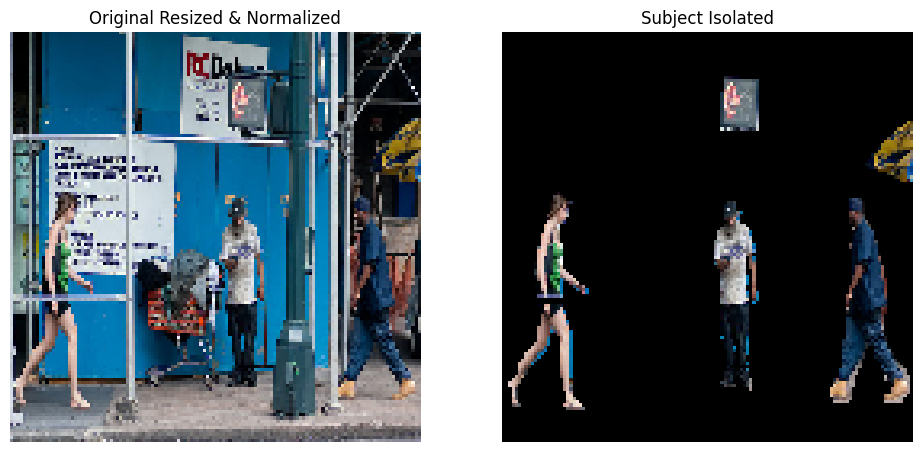

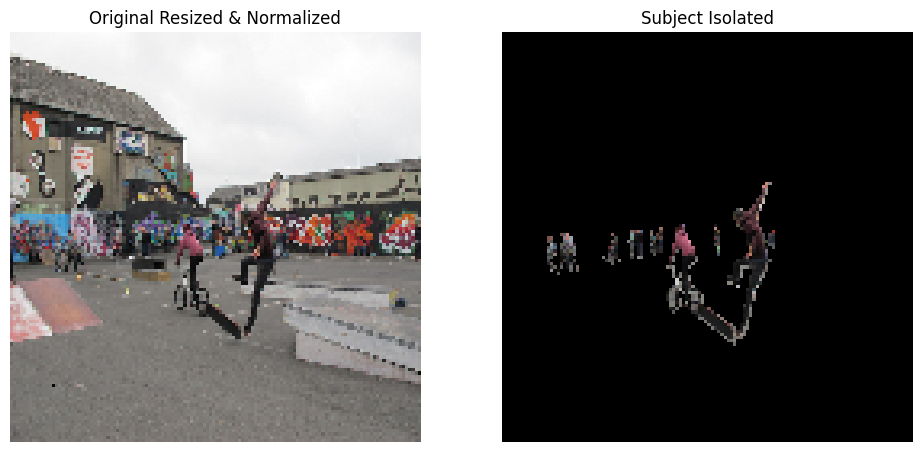

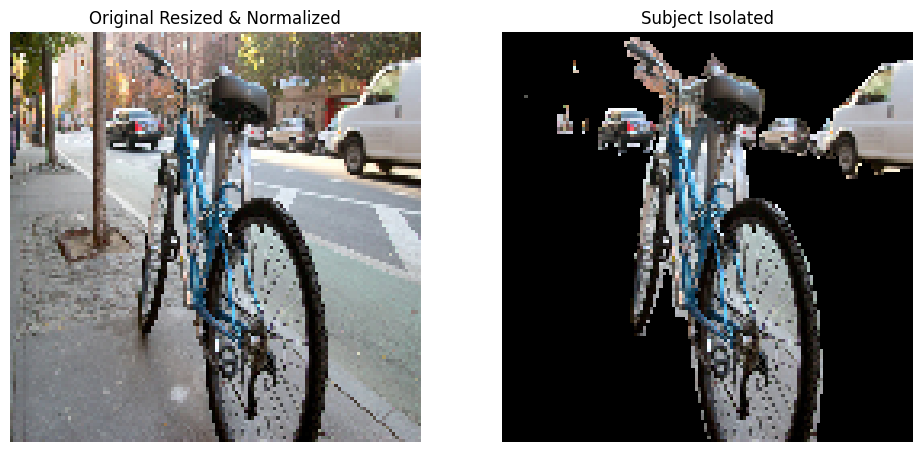

In [8]:
# ==============================
# WEEK 2: PREPROCESSING PIPELINE (Corrected Augmentation)
# ==============================

# Step 1: Import Libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from pycocotools.coco import COCO
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ==============================
# Step 2: Set Dataset Paths
# ==============================
DATA_ROOT = "/content/drive/MyDrive/VisionAI"  # Update your path
IMAGES_DIR = os.path.join(DATA_ROOT, "val2017")  # or train2017
ANN_FILE = os.path.join(DATA_ROOT, "annotations", "instances_val2017.json")

coco = COCO(ANN_FILE)
img_ids = coco.getImgIds()
print("Total images:", len(img_ids))

# ==============================
# Step 3: Function - Build Binary Mask
# ==============================
def build_binary_mask(coco, img_info):
    ann_ids = coco.getAnnIds(imgIds=img_info['id'], iscrowd=False)
    anns = coco.loadAnns(ann_ids)
    mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
    for ann in anns:
        mask = np.maximum(mask, coco.annToMask(ann))
    return np.clip(mask, 0, 1)

# ==============================
# Step 4: Function - Preprocess Image & Mask
# ==============================
def preprocess_image_and_mask(img, mask, target_size=(128,128)):
    img = cv2.resize(img, target_size)
    mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
    img = img / 255.0
    mask = (mask > 0).astype(np.uint8)
    return img, mask

# ==============================
# Step 5: Function - Subject Isolation
# ==============================
def isolate_subject(img, mask):
    mask_3c = np.stack([mask]*3, axis=-1)
    return img * mask_3c

# ==============================
# Step 6: Data Augmentation Setup
# ==============================
data_gen_args = dict(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=15,
    brightness_range=[0.8, 1.2]
)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen  = ImageDataGenerator(**data_gen_args)

# ==============================
# Step 7: Pipeline Execution - First 5 Images
# ==============================
num_samples = 5
for img_id in img_ids[:num_samples]:

    # 1 Load image
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(IMAGES_DIR, img_info['file_name'])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 2 Build binary mask (multi-class to binary)
    mask = build_binary_mask(coco, img_info)

    # 3 Preprocess image & mask (resize, normalize, alignment)
    img_proc, mask_proc = preprocess_image_and_mask(img, mask)

    # 4 Subject isolation
    isolated_img = isolate_subject(img_proc, mask_proc)

    # 5 Apply augmentation (1 augmented version)
    img_aug = img_proc[np.newaxis,...]
    mask_aug = mask_proc[np.newaxis,...,np.newaxis]

    aug_iter = zip(
        image_datagen.flow(img_aug, batch_size=1, seed=42),
        mask_datagen.flow(mask_aug, batch_size=1, seed=42)
    )

    img_augmented, mask_augmented = next(aug_iter)

    # ✅ Corrected mask: threshold to keep binary after augmentation
    mask_augmented_bin = (mask_augmented[0,:,:,0] > 0.5).astype(np.uint8)

    # Subject isolation for augmented image
    isolated_aug = isolate_subject(img_augmented[0], mask_augmented_bin)

    # 6️⃣ Display results
    plt.figure(figsize=(18,6))

    plt.subplot(1,3,1)
    plt.imshow(img_proc)
    plt.title("Original Resized & Normalized")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(isolated_img)
    plt.title("Subject Isolated")
    plt.axis("off")


    plt.show()


In [6]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [9]:
cats = coco.loadCats(coco.getCatIds())
for cat in cats:
    print(cat['id'], cat['name'])


1 person
2 bicycle
3 car
4 motorcycle
5 airplane
6 bus
7 train
8 truck
9 boat
10 traffic light
11 fire hydrant
13 stop sign
14 parking meter
15 bench
16 bird
17 cat
18 dog
19 horse
20 sheep
21 cow
22 elephant
23 bear
24 zebra
25 giraffe
27 backpack
28 umbrella
31 handbag
32 tie
33 suitcase
34 frisbee
35 skis
36 snowboard
37 sports ball
38 kite
39 baseball bat
40 baseball glove
41 skateboard
42 surfboard
43 tennis racket
44 bottle
46 wine glass
47 cup
48 fork
49 knife
50 spoon
51 bowl
52 banana
53 apple
54 sandwich
55 orange
56 broccoli
57 carrot
58 hot dog
59 pizza
60 donut
61 cake
62 chair
63 couch
64 potted plant
65 bed
67 dining table
70 toilet
72 tv
73 laptop
74 mouse
75 remote
76 keyboard
77 cell phone
78 microwave
79 oven
80 toaster
81 sink
82 refrigerator
84 book
85 clock
86 vase
87 scissors
88 teddy bear
89 hair drier
90 toothbrush


In [10]:
def build_binary_mask_main_subject(coco, img_info, main_category_name="person"):
    """
    Convert multi-class mask into a binary mask for the main subject only
    """
    # Get category_id for the main subject
    cat_ids = coco.getCatIds(catNms=[main_category_name])

    # Get all annotations for this image that belong to this category
    ann_ids = coco.getAnnIds(imgIds=img_info['id'], catIds=cat_ids, iscrowd=False)
    anns = coco.loadAnns(ann_ids)

    # Initialize empty mask
    mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)

    # Add only main subject annotations
    for ann in anns:
        mask = np.maximum(mask, coco.annToMask(ann))

    # Ensure binary mask: 0 = background, 1 = main subject
    return (mask > 0).astype(np.uint8)


In [11]:
mask = build_binary_mask(coco, img_info)
mask = build_binary_mask_main_subject(coco, img_info, main_category_name="person")


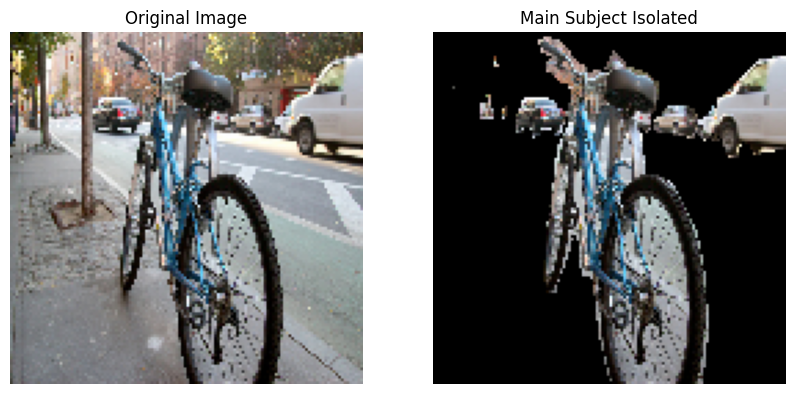

In [12]:
isolated_img = isolate_subject(img_proc, mask_proc)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img_proc)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(isolated_img)
plt.title("Main Subject Isolated")
plt.axis("off")
plt.show()


In [18]:
def build_binary_mask_main_subject(coco, img_info, main_category_name="person"):
    # Get category_id for the main subject
    cat_ids = coco.getCatIds(catNms=[main_category_name])

    # Get annotations for this image that belong to this category
    ann_ids = coco.getAnnIds(imgIds=img_info['id'], catIds=cat_ids, iscrowd=False)
    anns = coco.loadAnns(ann_ids)

    # Build mask
    mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
    for ann in anns:
        mask = np.maximum(mask, coco.annToMask(ann))

    # Convert to binary
    return (mask > 0).astype(np.uint8)


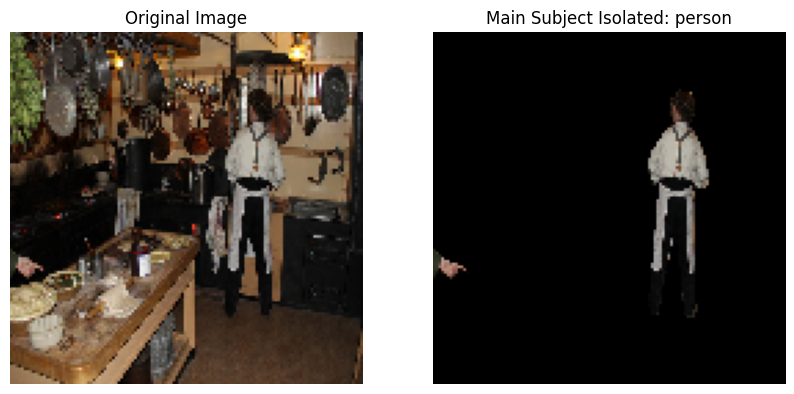

In [19]:
img_info = coco.loadImgs(img_ids[0])[0]
img_path = os.path.join(IMAGES_DIR, img_info['file_name'])
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask = build_binary_mask_main_subject(coco, img_info, main_category_name=main_subject_name)
img_proc, mask_proc = preprocess_image_and_mask(img, mask)
isolated_img = isolate_subject(img_proc, mask_proc)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img_proc)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(isolated_img)
plt.title(f"Main Subject Isolated: {main_subject_name}")
plt.axis("off")
plt.show()


loading annotations into memory...
Done (t=0.67s)
creating index...
index created!
Main subject: person | Category ID: 1


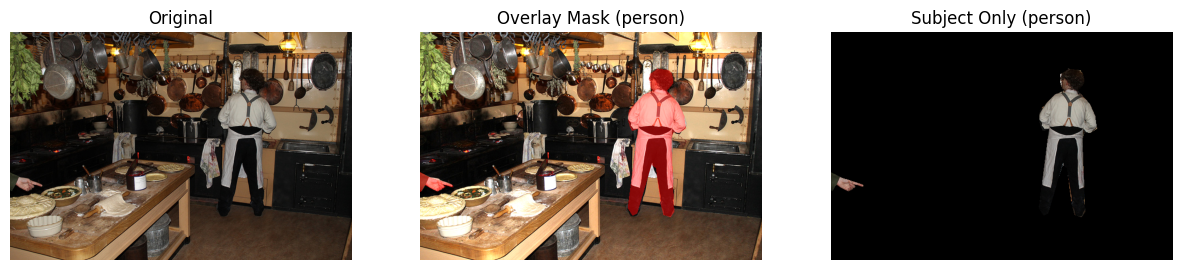

⚠️ No 'person' found in image: 000000037777.jpg


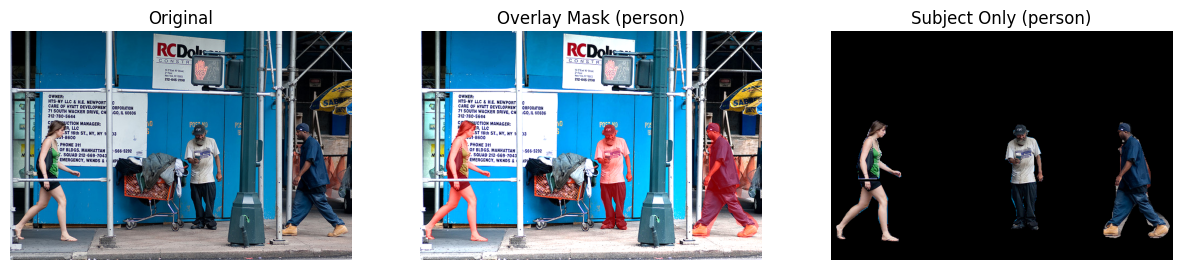

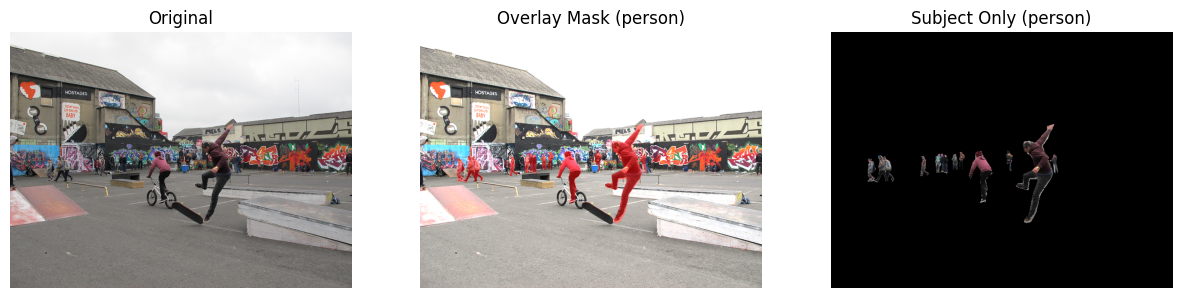

⚠️ No 'person' found in image: 000000174482.jpg


In [24]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO

# ==== STEP 1: Setup Paths ====
ANN_FILE = "/content/drive/MyDrive/VisionAI/annotations/instances_val2017.json"
IMAGES_DIR = "/content/drive/MyDrive/VisionAI/val2017"
coco = COCO(ANN_FILE)

# ==== STEP 2: Pick main subject ====
main_subject_name = "person"   # change to 'dog', 'car', etc.
main_subject_cat_id = coco.getCatIds(catNms=[main_subject_name])[0]
print("Main subject:", main_subject_name, "| Category ID:", main_subject_cat_id)

# ==== STEP 3: Build binary mask for the chosen subject ====
def build_binary_mask_main_subject(coco, img_info, main_category_name="person"):
    cat_ids = coco.getCatIds(catNms=[main_category_name])
    ann_ids = coco.getAnnIds(imgIds=img_info['id'], catIds=cat_ids, iscrowd=False)
    anns = coco.loadAnns(ann_ids)

    mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
    for ann in anns:
        mask = np.maximum(mask, coco.annToMask(ann))

    return (mask > 0).astype(np.uint8)

# ==== STEP 4: Process multiple images ====
img_ids = coco.getImgIds()[:5]  # first 5 images

for img_id in img_ids:
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(IMAGES_DIR, img_info['file_name'])

    # Check image exists
    if not os.path.exists(img_path):
        print(f" Image not found: {img_path}")
        continue

    # Load image
    image = cv2.imread(img_path)
    if image is None:
        print(f" Failed to load image: {img_path}")
        continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Build mask
    mask = build_binary_mask_main_subject(coco, img_info, main_category_name=main_subject_name)

    # Check mask is not empty
    if mask.sum() == 0:
        print(f" No '{main_subject_name}' found in image: {img_info['file_name']}")
        continue

    # 1. Overlay mask (red transparent)
    overlay = image.copy()
    overlay[mask == 1] = [255, 0, 0]
    alpha = 0.5
    overlayed = cv2.addWeighted(image, 1, overlay, alpha, 0)

    # 2. Subject only (keep original color, background black)
    subject_only = image.copy()
    subject_only[mask == 0] = 0

    # ==== Display Results ====
    plt.figure(figsize=(15,5))

    plt.subplot(1,3,1)
    plt.imshow(image)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(overlayed)
    plt.title(f"Overlay Mask ({main_subject_name})")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(subject_only)
    plt.title(f"Subject Only ({main_subject_name})")
    plt.axis("off")

    plt.show()
